## 프로젝트: 인물 모드 문제점 찾기

In [1]:
# importlib: 사용자가 파이썬의 import 시스템과 상호작용하기 위한 API를 제공하는 내장 라이브러리
# 사용자는 import 함수의 구현 내용과, 실행에 필요한 하위 함수들을 이용해 필요에 맞는 임포터를 직접 구현하거나 임포트 관련 기능들을 자유롭게 사용할 수 있음
# importlib.metadata: 설치된 패키지 메타 데이터에 대한 접근을 제공하는 라이브러리.
# 해당 코드 블럭에서는 importlib.metadata 안에 있는 version() 함수를 이용하여 pixellib 라이브러리의 버전을 확인

from importlib.metadata import version
import cv2
import pixellib

print(cv2.__version__)
print(version('pixellib'))

4.5.3
0.7.1


#### Step 1. 인물모드 직접 해 보기

- 여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다. 아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.
- 인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다. 시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.
- 배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경 합성을 시도해 볼 수도 있을 것입니다. 여러분만의 환상적인 사진을 만들어 보면 어떨까요?

### Step 0. 사진 준비

In [2]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


(249, 360, 3)


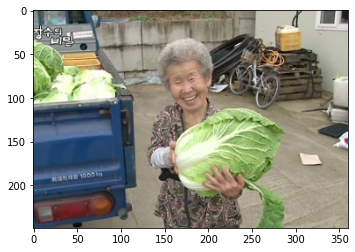

In [4]:
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/cabbage_grandma.png'  
img_orig = cv2.imread(img_path) 

print(img_orig.shape)

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()

### Step 1. 분리하기(세그멘테이션) - 누끼따기(인물부분만)

In [5]:
# 저장할 파일 이름을 결정합니다
# 1. os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. model_dir 에 "/aiffel/human_segmentation/models" 저장
# 2. #os.path.join(a, b)는 경로를 병합하여 새 경로 생성 model_file 에 "/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5" 저장
# 1
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models' 
# 2
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5') 

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5' 

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file) # urllib 패키지 내에 있는 request 모듈의 urlretrieve 함수를 이용해서 model_url에 있는 파일을 다운로드 해서 model_file 파일명으로 저장

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7fd1790deca0>)

In [6]:
model = semantic_segmentation() #PixelLib 라이브러리 에서 가져온 클래스를 가져와서 semantic segmentation을 수행하는 클래스 인스턴스를 만듬
model.load_pascalvoc_model(model_file) # pascal voc에 대해 훈련된 예외 모델(model_file)을 로드하는 함수를 호출

In [7]:
segvalues, output = model.segmentAsPascalvoc(img_path) # segmentAsPascalvoc()함 수 를 호출 하여 입력된 이미지를 분할, 분할 출력의 배열을 가져옴, 분할 은 pacalvoc 데이터로 학습된 모델을 이용

In [8]:
#pascalvoc 데이터의 라벨종류
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

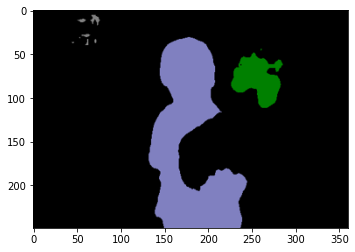

In [9]:
#segmentAsPascalvoc() 함수 를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 output을 matplotlib을 이용해 출력
plt.imshow(output)
plt.show()

In [10]:
segvalues # segmentAsPascalvoc() 함수를 호출하여 입력된 이미지를 분할한 뒤 나온 결과값 중 배열값을 출력

{'class_ids': array([ 0,  2,  7, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [11]:
#segvalues에 있는 class_ids를 담겨있는 값을 통해 pacalvoc에 담겨있는 라벨을 출력
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
bicycle
car
person


In [13]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 색상 코드 결과물이예요!

#컬러맵 만들기 
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20] #생성한 20개의 컬러맵 출력

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [14]:
colormap[15] #컬러맵 15에 해당하는 배열 출력 (pacalvoc에 LABEL_NAMES 15번째인 사람)

array([192, 128, 128])

In [15]:
seg_color = (128,128,192) # 색상순서 변경 - colormap의 배열은 RGB 순이며 output의 배열은 BGR 순서로 채널 배치가 되어 있어서

(249, 360)


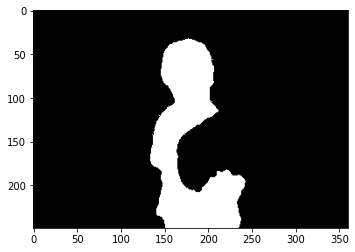

In [16]:
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
# seg_color 값이 person을 값이 므로 사람이 있는 위치를 제외하고는 gray로 출력
# cmap 값을 변경하면 다른 색상으로 확인이 가능함
seg_map = np.all(output==seg_color, axis=-1) 
print(seg_map.shape) 
plt.imshow(seg_map, cmap='gray')
plt.show()

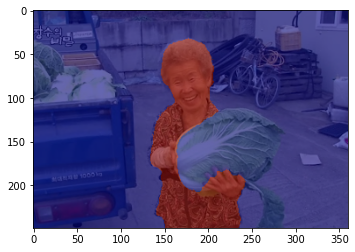

In [17]:
# 원본이미지를 img_show에 할당한뒤 이미지 사람이 있는 위치와 배경을 분리해서 표현한 color_mask 를 만든뒤 두 이미지를 합쳐서 출력
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.4, color_mask, 0.6, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

### Step1.1 아웃포커싱 효과 - 인물모드 사진 (배경 블러)
- 배경 흐리게 처리하여 인물을 돋보이게 하기

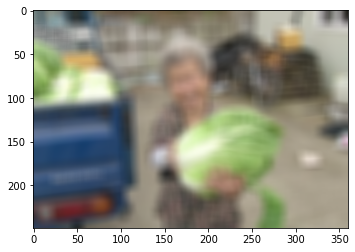

In [18]:
img_orig_blur = cv2.blur(img_orig, (13,13))
  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

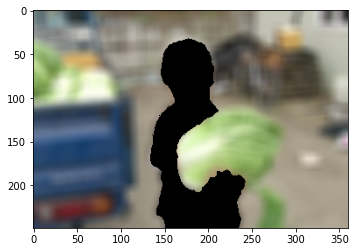

In [19]:
# 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)

img_bg_mask = cv2.bitwise_not(img_mask_color)

img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

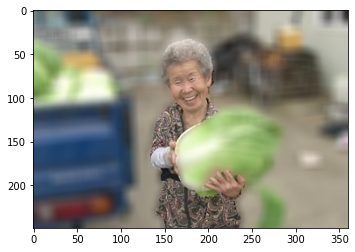

In [20]:
# 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

### Step1.2 아웃포커싱 효과 - 동물 사진

(564, 750, 3)


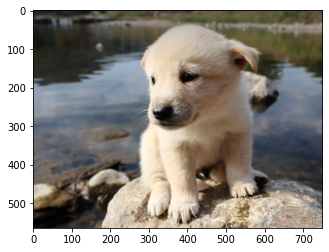

In [35]:
img_path_2 = os.getenv('HOME')+'/aiffel/human_segmentation/cute.png'  
img_orig_2 = cv2.imread(img_path_2) 

print(img_orig_2.shape)

plt.imshow(cv2.cvtColor(img_orig_2, cv2.COLOR_BGR2RGB))
plt.show()

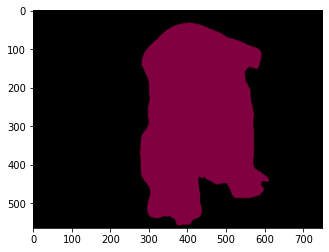

In [36]:
segvalues, output_2 = model.segmentAsPascalvoc(img_path_2)  # output_2, imag_path_2

plt.imshow(output_2)
plt.show()

In [40]:
segvalues

{'class_ids': array([ 0, 12]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [41]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
dog


In [43]:
colormap[12] #dog_RGB

array([ 64,   0, 128])

(564, 750)


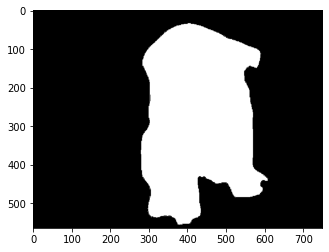

In [45]:
seg_color_2 = (128,0,64) #BGR

#seg_color = (128,128,192)
seg_map_2 = np.all(output_2==seg_color_2, axis=-1) 
print(seg_map_2.shape) 
plt.imshow(seg_map_2, cmap='gray')
plt.show()

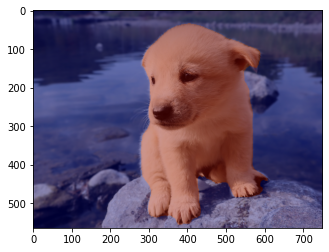

In [49]:
img_show_2 = img_orig_2.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask_2 = seg_map_2.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask_2 = cv2.applyColorMap(img_mask_2, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show_2 = cv2.addWeighted(img_show_2, 0.6, color_mask_2, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show_2, cv2.COLOR_BGR2RGB))
plt.show()

#### 반짝이는 효과 주기

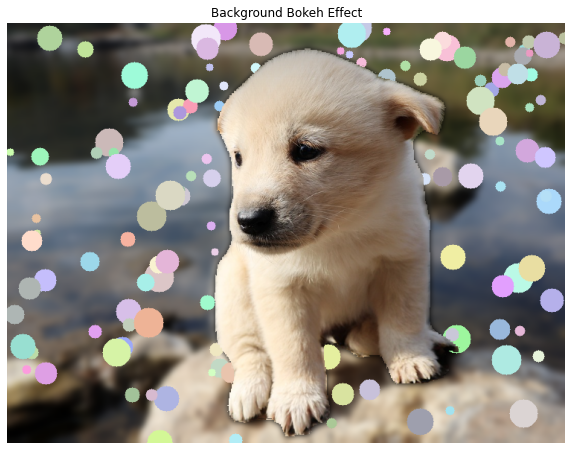

In [54]:
import random

# 원본 이미지 로드
img_path_2 = os.getenv('HOME') + '/aiffel/human_segmentation/cute.png'  
img_orig_2 = cv2.imread(img_path_2)

# 세그멘테이션을 통해 마스크 추출
segvalues, output_2 = model.segmentAsPascalvoc(img_path_2)

# 배경 마스크 추출
background_mask = (img_mask_2 == 0).astype(np.uint8)  # 배경은 0인 영역
background = cv2.bitwise_and(img_orig_2, img_orig_2, mask=background_mask)  # 배경 추출

# 보케 효과 적용: 흐림 처리
blurred_background = cv2.GaussianBlur(background, (25, 25), 0)

# 보케 효과 추가
for _ in range(200):  # 보케 점 개수
    # 랜덤 좌표 생성
    x = random.randint(0, img_orig_2.shape[1] - 1)
    y = random.randint(0, img_orig_2.shape[0] - 1)

    # 밝은 영역에서만 보케 효과 추가
    if blurred_background[y, x].mean() > 50:  # 밝은 영역 기준 설정
        radius = random.randint(5, 20)  # 보케 크기
        color = (random.randint(150, 255), random.randint(150, 255), random.randint(150, 255))  # 보케 색상 (밝은 색)
        thickness = -1  # 채워진 원

        # 보케 효과 그리기
        cv2.circle(blurred_background, (x, y), radius, color, thickness)

# 원본 이미지와 보케 효과 결합
final_result = np.where(background_mask[:, :, None] == 0, img_orig_2, blurred_background)

# 결과 시각화
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(final_result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Background Bokeh Effect")
plt.show()


### Step1.3 배경전환 크로마키사진

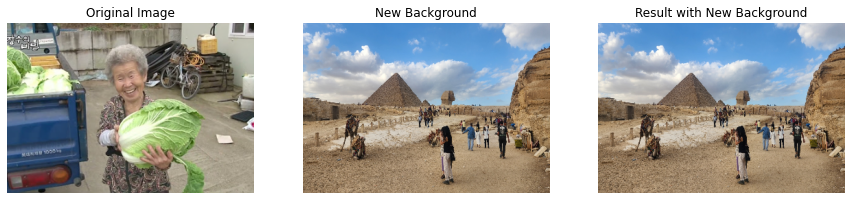

In [58]:
# 1. 원본 인물 이미지 로드
img_path_3 = os.getenv('HOME') + '/aiffel/human_segmentation/cabbage_grandma.png'  
img_orig_3 = cv2.imread(img_path_3)
img_orig_3 = cv2.cvtColor(img_orig_3, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환

# 2. 새로운 배경 이미지 로드
new_background_path = os.getenv('HOME') + '/aiffel/human_segmentation/background.jpg'  # 배경 이미지 경로
new_background = cv2.imread(new_background_path)
new_background = cv2.cvtColor(new_background, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환

# 3. 시맨틱 세그멘테이션 수행
segvalues, output_3 = model.segmentAsPascalvoc(img_path_3)  # PixelLib 모델을 사용하여 세그멘테이션 수행

# 4. 인물 마스크 생성
# "person" 클래스에 해당하는 색상으로 마스크 생성
seg_color_3 = (128, 0, 0)  # PASCAL VOC에서 "person" 클래스 색상
seg_map_3 = np.all(output_3 == seg_color_3, axis=-1).astype(np.uint8) * 255  # 마스크 생성

# 5. 새로운 배경 이미지 크기 조정
new_background = cv2.resize(new_background, (img_orig_3.shape[1], img_orig_3.shape[0]))  # 원본 크기에 맞게 조정

# 6. 마스크 반전 및 배경 처리
inverted_mask = cv2.bitwise_not(seg_map_3)  # 마스크 반전 (배경 영역만 추출)
background_with_new = cv2.bitwise_and(new_background, new_background, mask=inverted_mask)  # 새 배경 처리
foreground_with_person = cv2.bitwise_and(img_orig_3, img_orig_3, mask=seg_map_3)  # 인물 영역만 남김

# 7. 인물과 배경 합성
result_3 = cv2.add(background_with_new, foreground_with_person)  # 새로운 배경과 인물 결합

# 8. 결과 시각화
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_orig_3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("New Background")
plt.imshow(new_background)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Result with New Background")
plt.imshow(result_3)
plt.axis('off')

plt.show()


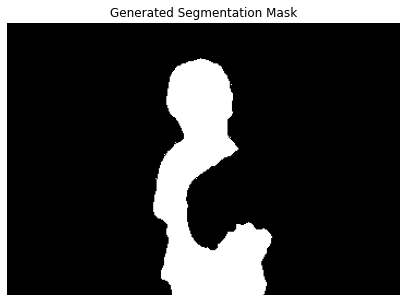

In [59]:
plt.figure(figsize=(10, 5))
plt.title("Generated Segmentation Mask")
plt.imshow(seg_map, cmap='gray')
plt.axis('off')
plt.show()


error: OpenCV(4.5.3) :-1: error: (-5:Bad argument) in function 'bitwise_and'
> Overload resolution failed:
>  - mask data type = 0 is not supported
>  - Expected Ptr<cv::UMat> for argument 'mask'


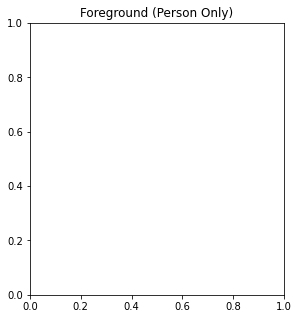

In [60]:
# 마스크로 추출된 인물 영역
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Foreground (Person Only)")
plt.imshow(cv2.bitwise_and(img_orig, img_orig, mask=seg_map))
plt.axis('off')

# 마스크로 추출된 배경 영역
plt.subplot(1, 2, 2)
plt.title("Background with New Background")
plt.imshow(cv2.bitwise_and(new_background, new_background, mask=inverted_mask))
plt.axis('off')

plt.show()


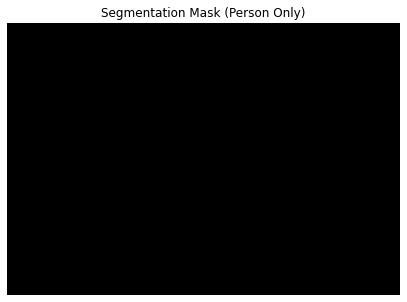

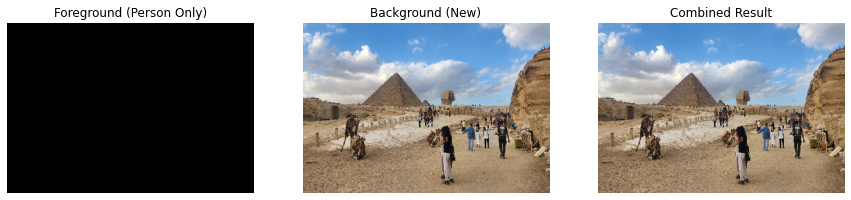

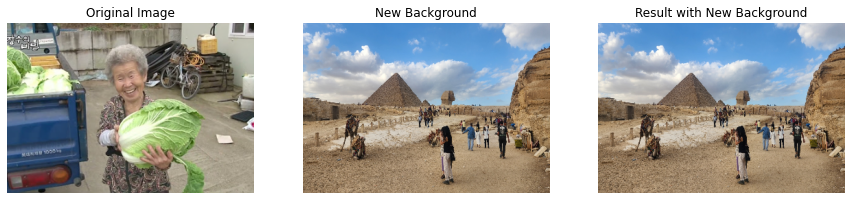

In [61]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. 원본 인물 이미지 로드
img_path_3 = os.getenv('HOME') + '/aiffel/human_segmentation/cabbage_grandma.png'  
img_orig_3 = cv2.imread(img_path_3)
img_orig_3 = cv2.cvtColor(img_orig_3, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환

# 2. 새로운 배경 이미지 로드
new_background_path = os.getenv('HOME') + '/aiffel/human_segmentation/background.jpg'  # 배경 이미지 경로
new_background = cv2.imread(new_background_path)
new_background = cv2.cvtColor(new_background, cv2.COLOR_BGR2RGB)  # BGR → RGB 변환

# 3. 시맨틱 세그멘테이션 수행
segvalues, output_3 = model.segmentAsPascalvoc(img_path_3)  # PixelLib 모델을 사용하여 세그멘테이션 수행

# 4. 인물 마스크 생성
# "person" 클래스에 해당하는 색상으로 마스크 생성
seg_color_3 = (128, 0, 0)  # PASCAL VOC에서 "person" 클래스 색상
seg_map_3 = np.all(output_3 == seg_color_3, axis=-1).astype(np.uint8) * 255  # 마스크 생성

# 5. 마스크 확인
plt.figure(figsize=(10, 5))
plt.title("Segmentation Mask (Person Only)")
plt.imshow(seg_map_3, cmap='gray')
plt.axis('off')
plt.show()

# 6. 새로운 배경 이미지 크기 조정
new_background = cv2.resize(new_background, (img_orig_3.shape[1], img_orig_3.shape[0]))  # 원본 크기에 맞게 조정

# 7. 마스크 반전 및 배경 처리
inverted_mask = cv2.bitwise_not(seg_map_3)  # 마스크 반전 (배경 영역만 추출)

# 배경과 인물 영역 각각 추출
background_with_new = cv2.bitwise_and(new_background, new_background, mask=inverted_mask)  # 새 배경 처리
foreground_with_person = cv2.bitwise_and(img_orig_3, img_orig_3, mask=seg_map_3)  # 인물 영역만 남김

# 8. 인물과 배경 합성
result_3 = cv2.add(background_with_new, foreground_with_person)  # 새로운 배경과 인물 결합

# 9. 중간 결과 확인
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title("Foreground (Person Only)")
plt.imshow(foreground_with_person)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Background (New)")
plt.imshow(background_with_new)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Combined Result")
plt.imshow(result_3)
plt.axis('off')
plt.show()

# 10. 최종 결과 시각화
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img_orig_3)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("New Background")
plt.imshow(new_background)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Result with New Background")
plt.imshow(result_3)
plt.axis('off')

plt.show()


#### Step 2. 사진에서 문제점 찾기

- 그러나 여러분들의 사진에는 무언가 문제점이 있을 것입니다.

- 아래 사진에도 문제점이 몇 가지 있었습니다. 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우입니다. ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.

- 추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다. 표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.

#### Step 3. 해결 방법을 제안해 보기

- 아주 간단히 멋진 카메라 앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금 같은 완성도로는 어림도 없습니다. 소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.

- 생각해 볼 만한 주제를 아래에 몇 가지 제시해 봅니다. 아래를 읽어본 후, 여러분이 만든 인물모드 사진의 문제점을 해결할 방안을 정리하여 제안해 주시기 바랍니다.
    - 단순히 'XXX 기술을 사용한다.' 정도의 선언적 솔루션이 아니라, 여러분들이 선택한 기술이 DeepLab 모델의 Semantic Segmentation 이 만들어 낸 Mask 영역에 어떻게 적용되어 문제점을 보완하게 되는지의 메커니즘이 포함된 솔루션이어야 합니다.  
    
    
    
- 세그멘테이션의 한계:  
Semantic segmentation의 부정확성이 여러 가지 문제를 발생시키는 주요 원인입니다. 피사계심도를 이용한 보케(아웃포커싱) 효과는 말 그대로 심도를 표현하기 때문에 초점이 잡힌 거리를 광학적으로 아주 섬세하게 구별(segmentation) 하지만 이를 따라 한 semantic segmentation 모듈은 정확도가 1.00 이 되지 않는 한 완벽히 구현하기는 힘듭니다.  


- 피사계 심도 이해하기:  
우선 피사계심도의 개념부터 명확히 이해해 봅시다.  


- 3D Camera 활용하기:  
이미지를 2D 방식으로 받아들이는 한계를 넘어 3D로 인식하려는 시도는 꽤 오래전부터 계속되어 왔습니다. 기술도 이제는 상당한 수준에 이르렀는데요. 크게는 스테레오 비전, ToF 방식 등이 자주 사용됩니다. 하드웨어 이미지 센서를 통한 3D 이미징 기술이 많이 발전되었는데요. 아래 참고 자료를 통해 최신 기술을 살펴봐도 좋습니다.  


- 소프트웨어 기술 활용하기:  
하드웨어 개발과 생산에는 비용이 많이 들기 때문에 제한된 하드웨어를 이용하면서 소프트웨어로 그 한계를 극복하려는 노력도 많습니다. 구글의 struct2Depth가 대표적인 예일 것 같습니다.  


- 다른 기술과 융합해 보기:  
구글 pixel4에는 IR(적외선) 카메라가 달려있는데요. 물체의 온도를 측정하는 IR 카메라와 3D 이미지는 크게 관련이 없을 것 같지만, 이를 통해 보다 멋진 3d depth sensing이 가능하다는군요.  

이렇게 카메라와 무관한 다른 기술과 융합하는 것도 좋은 해결책이 될 수 있습니다. 한 번 고민해 보세요!

이 외에도 다른 방식으로 접근해도 좋습니다. 엔지니어로서 본인이 선택한 솔루션을 잘 설명해 주세요. 가능하다면 순서도(Flow Chart)를 활용하면 좋습니다. 멋진 아이디어를 기대하겠습니다!!